In [1]:
import numpy as np 
import pandas as pd 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score
import matplotlib.pyplot as plt 
%matplotlib inline

dropouts = pd.read_csv(r"dropouts.csv", index_col=0)
enrollments = pd.read_csv(r"enrollments.csv", index_col=0)
factors = pd.read_csv(r"factors.csv", index_col=0)

dropouts_clusters = pd.read_csv(r"dropouts_clusters.csv", index_col=0)
enrollments_clusters = pd.read_csv(r"enrollments_clusters.csv", index_col=0)
factors_clusters = pd.read_csv(r"factors_clusters.csv", index_col=0)

In [2]:
dropouts.State.str.strip()
dropouts.State.replace({'A & N Islands':'Andaman & Nicobar Islands','Arunachal  Pradesh':'Arunachal Pradesh','Jammu & Kashmir':'Jammu And Kashmir','Madhya  Pradesh':'Madhya Pradesh','Pondicherry':'Puducherry','Tamil  Nadu':'Tamil Nadu','Uttaranchal':'Uttarakhand'},inplace=True)
enrollments.State.replace({'Uttaranchal':'Uttarakhand','Pondicherry':'Puducherry'},inplace=True)

In [3]:
enrollments.drop(['Labels'],axis=1,inplace=True)
dropouts.drop(['Labels'],axis=1,inplace=True)
factors.drop(['Labels'],axis=1,inplace=True)
enrollments.set_index('State',inplace=True)
dropouts.set_index('State',inplace=True)
factors.set_index('State_UT',inplace=True)

In [4]:
dataset = pd.concat([dropouts,enrollments,factors],axis=1)
cols=[]
for col in dataset.columns[:4]:
    cols.append("Dropout-"+col[:-6])
for col in dataset.columns[4:8]:
    cols.append("Enrollments-"+col[:-6])
for col in dataset.columns[8:]:
    cols.append(col)  
dataset.columns=cols

In [5]:
dataset.head(5)

,Dropout-PRIMARY,Dropout-UPPER_PRIMARY,Dropout-SECONDARY,Dropout-HRSECONDARY,Enrollments-Primary,Enrollments-Upper_Primary,Enrollments-Secondary,Enrollments-Higher_Secondary,Drinking water,Electricity,Computer,Boys toilet,Girls toilet
Andaman & Nicobar Islands,0.800000,1.143333,7.543333,15.646667,100.216667,91.126667,78.386667,54.000000,98.69,88.86,53.06,94.52,93.44
Andhra Pradesh,4.750000,4.113333,13.693333,4.046667,91.260000,87.863333,93.243333,90.000000,90.35,90.34,29.57,56.88,81.31
Arunachal Pradesh,12.290000,6.590000,14.843333,13.533333,89.810000,81.456667,74.370000,57.000000,79.79,36.35,24.28,48.73,76.90
Assam,9.680000,8.253333,28.086667,3.976667,127.783333,122.200000,89.300000,64.666667,80.30,19.39,8.85,60.17,75.28
Bihar,0.696667,2.353333,27.123333,0.000000,111.500000,94.013333,74.526667,34.333333,92.53,9.96,5.47,73.42,75.41


In [6]:
df=dataset.corr()
df.style.background_gradient(cmap="RdPu")

,Dropout-PRIMARY,Dropout-UPPER_PRIMARY,Dropout-SECONDARY,Dropout-HRSECONDARY,Enrollments-Primary,Enrollments-Upper_Primary,Enrollments-Secondary,Enrollments-Higher_Secondary,Drinking water,Electricity,Computer,Boys toilet,Girls toilet
Dropout-PRIMARY,1.000000,0.807927,0.282216,-0.207872,0.388448,0.234709,0.097505,0.127885,-0.694878,-0.623979,-0.536097,-0.529139,-0.365347
Dropout-UPPER_PRIMARY,0.807927,1.000000,0.519793,-0.194535,0.283531,0.225341,0.242735,0.255922,-0.634118,-0.569861,-0.492484,-0.471883,-0.347094
Dropout-SECONDARY,0.282216,0.519793,1.000000,-0.318201,0.308978,0.160214,-0.069190,-0.090104,-0.350441,-0.512970,-0.520840,-0.386027,-0.380618
Dropout-HRSECONDARY,-0.207872,-0.194535,-0.318201,1.000000,-0.201234,-0.077726,-0.006705,-0.072871,0.068208,0.358018,0.397225,0.124698,0.223931
Enrollments-Primary,0.388448,0.283531,0.308978,-0.201234,1.000000,0.745753,0.037681,-0.216058,-0.497725,-0.192635,-0.168423,-0.336579,-0.322224
Enrollments-Upper_Primary,0.234709,0.225341,0.160214,-0.077726,0.745753,1.000000,0.497824,0.101558,-0.295847,-0.033049,-0.101158,-0.191033,-0.111925
Enrollments-Secondary,0.097505,0.242735,-0.069190,-0.006705,0.037681,0.497824,1.000000,0.692828,-0.104459,-0.033538,-0.075523,-0.024754,0.009368
Enrollments-Higher_Secondary,0.127885,0.255922,-0.090104,-0.072871,-0.216058,0.101558,0.692828,1.000000,-0.150362,-0.114970,-0.305375,-0.253910,-0.192913
Drinking water,-0.694878,-0.634118,-0.350441,0.068208,-0.497725,-0.295847,-0.104459,-0.150362,1.000000,0.639871,0.462575,0.687693,0.743892
Electricity,-0.623979,-0.569861,-0.512970,0.358018,-0.192635,-0.033049,-0.033538,-0.114970,0.639871,1.000000,0.752674,0.490077,0.599604


## Maximum features are not linearly related. So we will shift them to a 

In [7]:
for i in range(df.shape[1]):
    df.iloc[:,i] = df.iloc[:,i] - df.iloc[:,i].mean()

In [8]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(df)
feature_imp = pd.Series(dict(zip(df.columns,pca.explained_variance_)))
feature_imp.index.name="Feature"
feature_imp.name="Explained variance"
pd.DataFrame(feature_imp)

,Explained variance
Feature,
Dropout-PRIMARY,2.339479e+00
Dropout-UPPER_PRIMARY,2.470111e-01
Dropout-SECONDARY,1.769748e-01
Dropout-HRSECONDARY,1.124167e-01
Enrollments-Primary,5.369884e-02
Enrollments-Upper_Primary,2.548767e-02
Enrollments-Secondary,1.316258e-02
Enrollments-Higher_Secondary,8.529529e-03
Drinking water,2.967537e-03


In [9]:
from sklearn.decomposition import TruncatedSVD
tc= TruncatedSVD(n_components=12)
tc.fit(dataset)
feature_imp = pd.Series(dict(zip(dataset.columns,tc.explained_variance_)))
feature_imp.index.name="Feature"
feature_imp.name="Explained variance"
pd.DataFrame(feature_imp)

,Explained variance
Feature,
Dropout-PRIMARY,481.666831
Dropout-UPPER_PRIMARY,1553.004128
Dropout-SECONDARY,438.828553
Dropout-HRSECONDARY,311.688649
Enrollments-Primary,208.254548
Enrollments-Upper_Primary,68.102667
Enrollments-Secondary,46.095268
Enrollments-Higher_Secondary,29.833240
Drinking water,27.065158


In [10]:
'''
from sklearn.manifold import TSNE
ts=TSNE(n_components=3)
ts.fit(dataset)
ts.plot()
'''

'\nfrom sklearn.manifold import TSNE\nts=TSNE(n_components=3)\nts.fit(dataset)\nts.plot()\n'

In [11]:
def create_clusters(x):
    
    states = x['index']
    states.columns=['State']
    x.drop(['index'],axis=1,inplace=True)

    scores=[]
    for i in range(4,36):
        k=KMeans(n_clusters=i,n_init=500, max_iter=500)
        k.fit(x)
        label=KMeans.predict(k,x)
        scores.append(silhouette_score(x, label))

    pd.DataFrame(scores).plot()
    best_cluster_no=np.argmax(scores[2:36])+2
    plt.axvline(best_cluster_no)
    plt.text(best_cluster_no, 0.34,s=f"Max silhoutte score at n={best_cluster_no}")
    plt.xlabel("No. of clusters")
    plt.ylabel("Silhoutte score")
    kk=KMeans(n_clusters=best_cluster_no)

    kk.fit(x)
    lab = pd.DataFrame(kk.labels_,columns=['Labels'])
    result=pd.concat([states,x,lab['Labels']],axis=1)
    return result

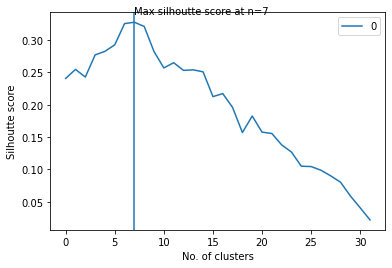

In [12]:
result=create_clusters(dataset.reset_index())

In [14]:
grouping=result[['index','Labels']]
clusters=pd.DataFrame()
for l in grouping.Labels.unique():
    clusters=pd.concat([clusters,pd.Series(np.array(grouping['index'][grouping.Labels==l]), name=f"Cluster {l}").to_frame()],axis=1)
clusters.replace({np.nan:'-'},inplace=True)
clusters.sort_index(axis=1, inplace=True)
clusters  

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6
0,Goa,Arunachal Pradesh,Chandigarh,Assam,Jammu And Kashmir,Andaman & Nicobar Islands,Chhattisgarh
1,Gujarat,Bihar,Daman & Diu,Meghalaya,Madhya Pradesh,Andhra Pradesh,Manipur
2,Tamil Nadu,Jharkhand,Delhi,Mizoram,-,Dadra & Nagar Haveli,Rajasthan
3,-,Odisha,Kerala,Nagaland,-,Haryana,Tripura
4,-,-,Lakshadweep,-,-,Himachal Pradesh,Uttar Pradesh
5,-,-,Puducherry,-,-,Karnataka,West Bengal
6,-,-,-,-,-,Maharashtra,-
7,-,-,-,-,-,Punjab,-
8,-,-,-,-,-,Sikkim,-
9,-,-,-,-,-,Telangana,-


In [13]:
reqd=result.groupby('Labels')[result.columns[1:-1]].agg('mean')
reqd.style.background_gradient(cmap='Greens')

,Dropout-PRIMARY,Dropout-UPPER_PRIMARY,Dropout-SECONDARY,Dropout-HRSECONDARY,Enrollments-Primary,Enrollments-Upper_Primary,Enrollments-Secondary,Enrollments-Higher_Secondary,Drinking water,Electricity,Computer,Boys toilet,Girls toilet
Labels,,,,,,,,,,,,,
0,0.871111,2.554444,13.265556,7.064444,109.407778,123.452222,107.403333,76.444444,99.526667,98.526667,55.616667,91.923333,98.333333
1,5.618333,4.927500,26.704167,3.667500,98.302500,86.880000,70.845833,45.250000,90.130000,22.635000,12.317500,71.107500,81.497500
2,0.323889,1.033333,10.556667,9.746111,95.570556,92.372222,81.761111,41.777778,99.900000,99.346667,88.125000,99.450000,99.565000
3,11.520000,9.305000,24.784167,4.857500,131.998333,123.149167,91.733333,55.416667,76.945000,39.182500,20.137500,68.757500,80.732500
4,6.898333,7.448333,19.140000,5.416667,88.260000,96.591667,116.256667,94.666667,93.040000,25.870000,14.880000,81.100000,84.855000
5,2.391818,2.747879,14.907879,6.922121,98.870909,92.444242,83.637576,61.333333,97.500909,90.588182,41.036364,89.980909,95.272727
6,6.021111,3.707778,15.264444,2.868333,100.483889,98.226111,90.736111,65.055556,94.391667,46.573333,16.466667,93.675000,96.860000


Things to do:
* PCA/SVD/t-SNE?
* How to combine and wrap everything together?
* Dim reduction before/ after clustering?
* Rank correlation??
